In [1]:
import sys
sys.path.append("../")

<center> This notebook is a practical application of the methods regarding the implementation of longstaff schwartz methods. 
<br>
<br>
In this notebook, to be able to compare the evolution of the price when increasing the number of simulations, we set the seed for the random generator
</center> 

In [2]:
import numpy as np
from typing import Callable
from tqdm import tqdm 
from scipy.stats import norm

from SDE.utils.random_generation import generate_n_gaussian, generate_n_gaussian_quasi, generate_n_gaussian_quasi_paths
from SDE.basket import Weighted_Basket, Basket
from SDE.bs import BS_Asset
import SDE.utils.montecarlo_utils as mc
from SDE.montecarlo import mcls_pricing

# <center> Path simulation </center>

In [3]:
################################################################
##################### BASKET DEFINITION ########################
################################################################

risk_free_rate = 0.05
T = 1
strike = 200
nb_assets = 3
nb_periods = 6
times_path = [i*T/nb_periods for i in range(nb_periods+1)]      # equal periods

# taking real life parameters found above
asset_AAPL = BS_Asset(169.300003,0.20,risk_free_rate)
asset_AMZN = BS_Asset(179,0.32,risk_free_rate)
asset_TSLA = BS_Asset(179.99,0.53,risk_free_rate)
correl_matrix = [[1.000000, 0.884748, 0.827503], [0.884748, 1.000000, 0.793269], [0.827503, 0.793269, 1.000000]]

adjusted_weights = [2*0.196889,2*0.18622,2*0.185195]

print("THE SEED IS SET TO FALSE -> same values generated + allowing to compare results")
my_basket_object = Weighted_Basket(adjusted_weights,[asset_AAPL,asset_AMZN,asset_TSLA],correl_matrix,live_seed=False)

# building estimating function 
payoff = lambda basket_value : np.exp(-risk_free_rate*T)*max(basket_value-strike,0)
h = my_basket_object.h(T,payoff)

THE SEED IS SET TO FALSE -> same values generated + allowing to compare results


### Pseudo-random

In [4]:
### ASSET SIMULATION ###
one_brownian_vec = [generate_n_gaussian(1) for _ in times_path]

asset_value_path = asset_AAPL.simulate_path_with_brownian(times_path, one_brownian_vec)
print([f"T:{round(t,2)} -> S:{round(b,2)}" for t, b in zip(times_path, asset_value_path)])

### BASKET SIMULATION ###
T = 1
times_path = [i * T / nb_periods for i in range(nb_periods + 1)]
two_brownians_vec = [generate_n_gaussian(nb_assets) for _ in times_path]

basket_value_path = my_basket_object.simulate_path_with_brownian(times_path, two_brownians_vec)
print([f"T:{round(t,2)} -> S:{round(b,2)}" for t, b in zip(times_path, basket_value_path)])

['T:0.0 -> S:169.3', 'T:0.17 -> S:170.55', 'T:0.33 -> S:171.82', 'T:0.5 -> S:173.09', 'T:0.67 -> S:174.37', 'T:0.83 -> S:175.66', 'T:1.0 -> S:176.96']
['T:0.0 -> S:200.0', 'T:0.17 -> S:197.16', 'T:0.33 -> S:194.66', 'T:0.5 -> S:192.47', 'T:0.67 -> S:190.57', 'T:0.83 -> S:188.94', 'T:1.0 -> S:187.58']


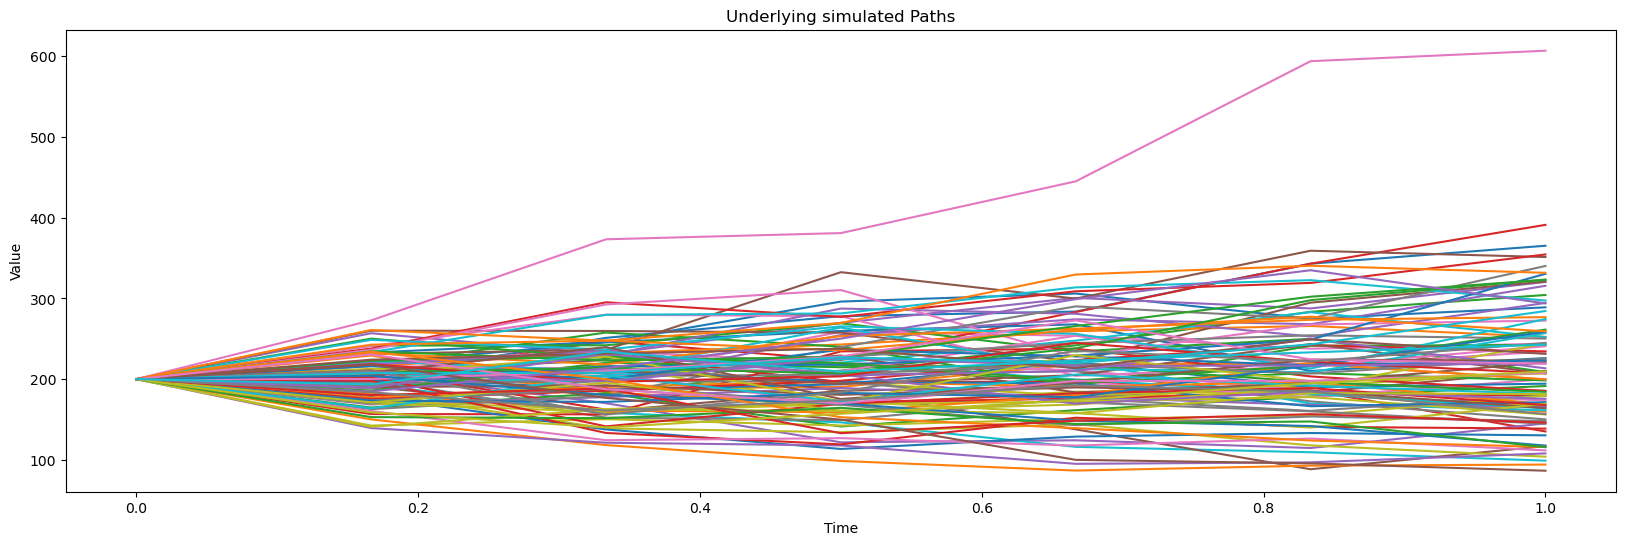

In [5]:
######################### PATH SIMULATIONS #########################
nb_simu_plot = 100

simulations_vec = [my_basket_object.simulate_path_with_brownian(times_path,w_vec) for w_vec in my_basket_object.generate_random_values_in_required_format(len(times_path))(nb_simu_plot)]

mc.plot_asset_paths(times_path, simulations_vec)

### Quasi-random

In [6]:
### ASSET SIMULATION ###
one_brownian_vec_quasi = [i[0] for i in generate_n_gaussian_quasi(1, len(times_path))]

asset_value_path_quasi = asset_AAPL.simulate_path_with_brownian(times_path, one_brownian_vec_quasi)
print([f"T:{round(t, 2)} -> S:{round(b, 2)}" for t, b in zip(times_path, asset_value_path_quasi)])

### BASKET SIMULATION ###
T = 1
times_path = [i * T / nb_periods for i in range(nb_periods + 1)]
two_brownians_vec_quasi = generate_n_gaussian_quasi(nb_assets, len(times_path))

basket_value_path_quasi = my_basket_object.simulate_path_with_brownian(times_path, two_brownians_vec_quasi)
print([f"T:{round(t,2)} -> S:{round(b,2)}" for t, b in zip(times_path, basket_value_path_quasi)])

['T:0.0 -> S:169.3', 'T:0.17 -> S:170.15', 'T:0.33 -> S:161.84', 'T:0.5 -> S:171.86', 'T:0.67 -> S:157.24', 'T:0.83 -> S:162.19', 'T:1.0 -> S:158.82']
['T:0.0 -> S:200.0', 'T:0.17 -> S:192.48', 'T:0.33 -> S:178.71', 'T:0.5 -> S:189.99', 'T:0.67 -> S:169.75', 'T:0.83 -> S:170.64', 'T:1.0 -> S:157.89']


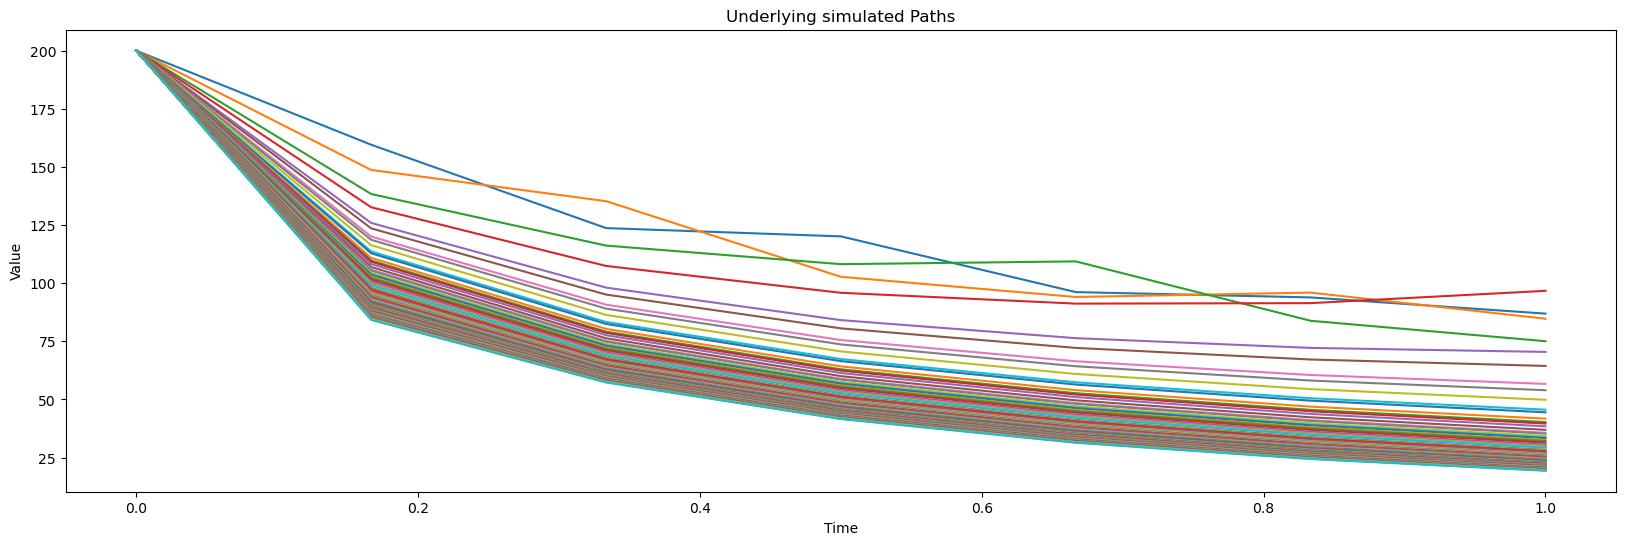

In [7]:
######################### PATH SIMULATIONS #########################
nb_simu_plot = 100
d_gaussian_path_vec_plot_quasi = generate_n_gaussian_quasi_paths(nb_assets, nb_simu_plot, len(times_path))

simulations_vec_quasi = [my_basket_object.simulate_path_with_brownian(times_path, brownians) for brownians in d_gaussian_path_vec_plot_quasi]

mc.plot_asset_paths(times_path, simulations_vec_quasi)

# <center> Longstaff schwartz computation </center>

## European price

In [8]:
mcls_pricing(underlying= my_basket_object , 
             actualisation_rate= risk_free_rate, 
             terminal_payoff_function= lambda x : max(x-strike,0), 
             exercise_times= [0,1], 
             nb_simulations = 90000, 
             verbose=False)

30.00275993243402

## Simple estimator

In [9]:
####### computing estimations #######
max_nb_simulations = 1000

price_converg_vec_pseudo = []
for i in tqdm(range(2,max_nb_simulations)):
    price_approx_pseudo = mcls_pricing(underlying= my_basket_object , 
             actualisation_rate= risk_free_rate, 
             terminal_payoff_function= lambda x : max(x-strike,0), 
             exercise_times= times_path, 
             nb_simulations = i,
             verbose = False,
             display_performance= False)

    price_converg_vec_pseudo.append(price_approx_pseudo)

100%|██████████| 998/998 [01:49<00:00,  9.12it/s]


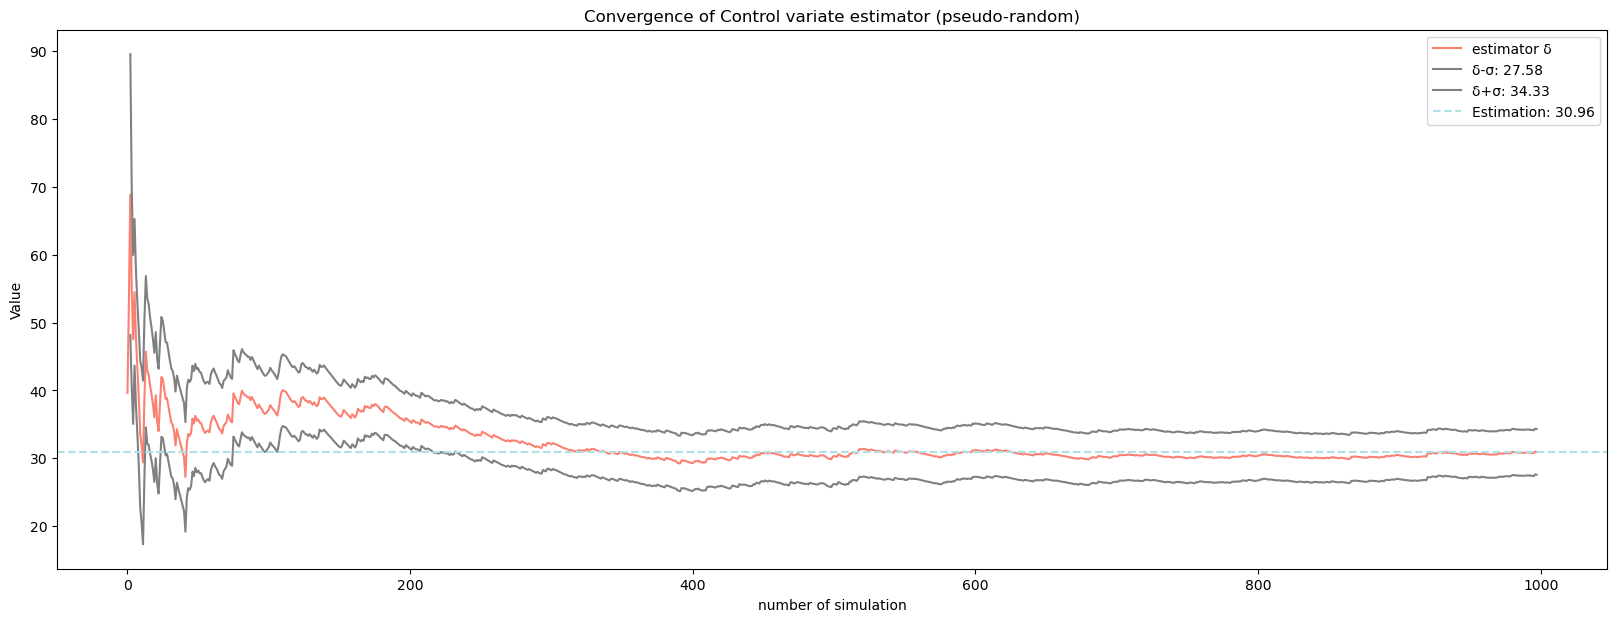

In [10]:
mc.display_single_estimators_IC(price_converg_vec_pseudo, "Convergence of Control variate estimator (pseudo-random)")

## Antithetic estimator

In [11]:
####### computing estimations #######
max_nb_simulations = 1000

price_converg_vec_anti = []
for i in tqdm(range(2,max_nb_simulations)):
    price_approx_anti = mcls_pricing(underlying= my_basket_object , 
             actualisation_rate= risk_free_rate, 
             terminal_payoff_function= lambda x : max(x-strike,0), 
             exercise_times= times_path, 
             nb_simulations = i,
             verbose = False,
             A_transformation = lambda x: -x,
             display_performance= False)

    price_converg_vec_anti.append(price_approx_anti)

 66%|██████▌   | 656/998 [01:31<00:47,  7.16it/s]


KeyboardInterrupt: 

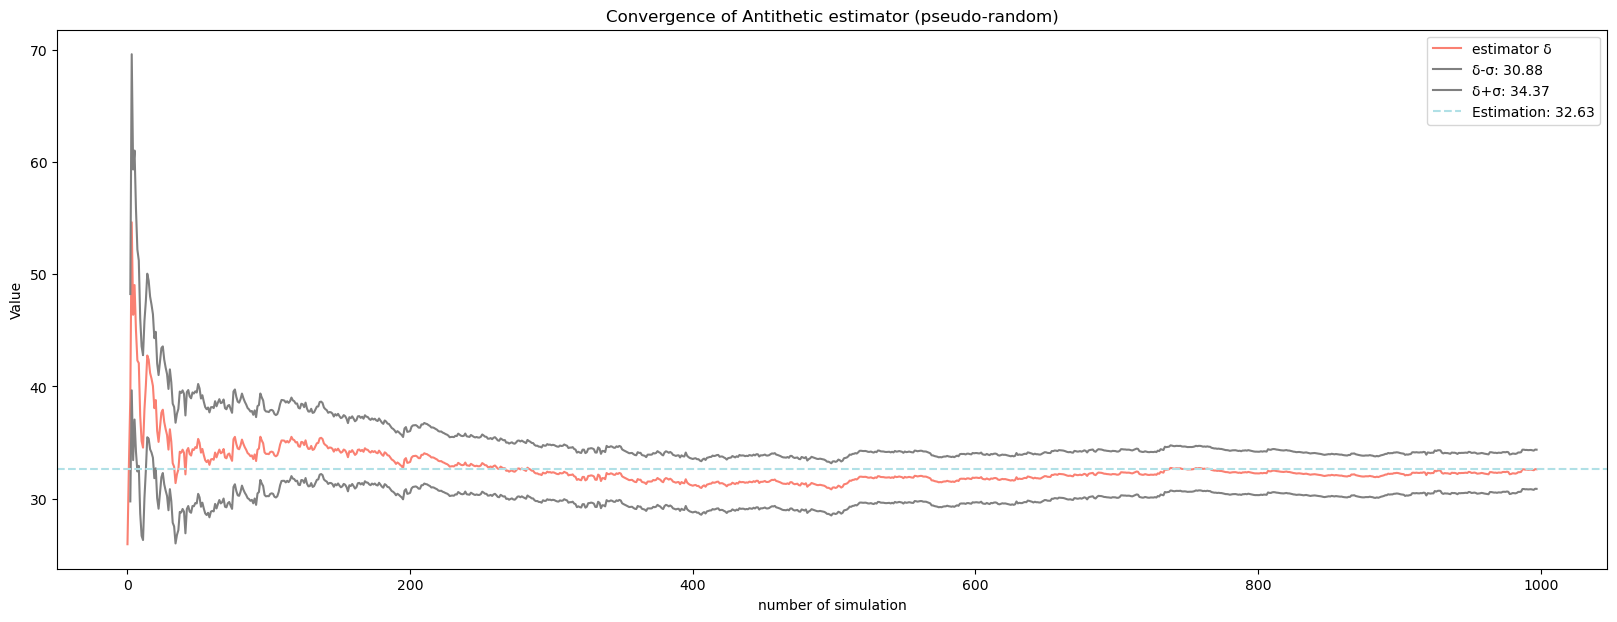

In [ ]:
mc.display_single_estimators_IC(price_converg_vec_anti, "Convergence of Antithetic estimator (pseudo-random)")

## Control variate estimator

In [ ]:
def m_function(basket_object:Basket,r,K,T):
    """
    computing E[h0(X)] for given basket and values
    """
    covar_matrix = basket_object.assetND.correl_matrix.m
    mu_star = np.array([alpha_i*a.vol*np.sqrt(T) for alpha_i,a in zip(basket_object.weights,basket_object.assetND.assets)])
    sigma_star = np.sqrt(np.dot(np.dot(mu_star.T,covar_matrix),mu_star))
    cst = np.exp(np.sum([alpha_i*(np.log(a.initial_spot)+(a.rf-a.vol**2/2)*T) for alpha_i,a in zip(basket_object.weights,basket_object.assetND.assets)]))   

    d1 = np.log(cst/K)/sigma_star + sigma_star
    d2 = d1 - sigma_star

    m = (cst*np.exp(0.5*sigma_star**2)*norm.cdf(d1) - K*norm.cdf(d2))*np.exp(-r*T)
    return m

def h0(brownian_path_vec,basket_object:Basket,times_path,payoff_function:Callable)-> Callable:
    """
    ** ATTENTION ** : payoff_function must be actualised if applying 

    payoff_function (func): payoff function computing the price for given underlying terminal values 
    Returns : 
        returns functions h0(((w1_0,...,w1_n),..,(wd_0,...,wd_n))) = payoff_function applied for log method for the given simulations to the basket

        >>> output : ((w1_0,...,w1_n),..,(wd_0,...,wd_n)) -> exp(sum(alpha_i*S_T_i)) = Mult(X_T((wi_0,...,wi_n))**alpha_i)
    """

    log_basket_terminal_value = basket_object.simulate_log_path_with_brownian(times_path,brownian_path_vec)[-1]

    return payoff_function(log_basket_terminal_value)

####### building estimator function #######
m_value = m_function(my_basket_object,risk_free_rate,strike,times_path[-1])

In [ ]:
####### computing estimations #######
max_nb_simulations = 1000

price_converg_vec_cont = []
for i in tqdm(range(2,max_nb_simulations)):
    price_converg_cont = mcls_pricing(underlying= my_basket_object , 
             actualisation_rate= risk_free_rate, 
             terminal_payoff_function= lambda x : max(x-strike,0), 
             exercise_times= times_path, 
             nb_simulations = i,
             verbose = False,
             A_transformation = None, #lambda x: -x,
             h0_function= lambda brownian_path_vec : h0(brownian_path_vec,my_basket_object,times_path,lambda x : np.exp(-risk_free_rate*T)*max(x-strike,0)),
             m_value=m_value,
             display_performance= False)

    price_converg_vec_cont.append(price_approx_anti)

  0%|          | 0/998 [00:00<?, ?it/s]/Users/max/Documents/M2_203/S2/Numerical finance/numerical_finance2/Results/../SDE/basket.py:75: RuntimeWarning: invalid value encountered in log
  log_basket_path = [np.exp(np.sum([alpha_i*np.log(S_i) for alpha_i,S_i in zip(self.weights,assets_value_vec)])) for assets_value_vec in asset_path_ND]
  2%|▏         | 16/998 [32:49<33:35:07, 123.12s/it]


KeyboardInterrupt: 

In [ ]:
mc.display_single_estimators_IC(price_converg_vec_cont, "Convergence of Control estimator (pseudo-random)")

## Control + Antithetic variate estimator

In [ ]:
####### computing estimations #######
max_nb_simulations = 1000

price_converg_vec_cont_anti = []
for i in tqdm(range(2,max_nb_simulations)):
    price_approx_cont_anti = mcls_pricing(underlying= my_basket_object , 
             actualisation_rate= risk_free_rate, 
             terminal_payoff_function= lambda x : max(x-strike,0), 
             exercise_times= times_path, 
             nb_simulations = i,
             verbose = False,
             A_transformation = None, #lambda x: -x,
             h0_function= lambda brownian_path_vec : h0(brownian_path_vec,my_basket_object,times_path,lambda x : np.exp(-risk_free_rate*T)*max(x-strike,0)),
             m_value=m_value,
             display_performance= False)

    price_converg_vec_cont_anti.append(price_approx_cont_anti)

In [ ]:
mc.display_single_estimators_IC(price_converg_vec_cont, "Convergence of Control & Antithetic estimator (pseudo-random)")